In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  4 07:02:45 2024

@author: robberto
"""

from astropy.io import fits
import matplotlib.pyplot as plt

import os
import shutil
import glob
import numpy as np
import pandas as pd
import copy
import heapq

from scipy.signal import find_peaks
import cv2

## """ Instantiate the clas with the correct directory name"""

In [3]:
data_path = "/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI"
from Class_SAMOS import SAMOS
SAMOS = SAMOS(data_path) 

working on the directory: /Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI


### Check the files you want to process here
https://www.stsci.edu/~robberto/Main/SAMOS/Run_October2024/SAMI/QL_20241017/overview.html

## SELECT A TARGET AND INSPECT THE FILES YOU MAY WANT TO USE. ANNOTATE BELOW

In [6]:
# DATA ANALYSIS 
target_name = "ABELL3120_manual_Mask_T00_Low_Red"

"""
=> Night 20241017
TARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]
FLATS  = target.028.fits [2s], calibration.029.fits [2s]
ARC_Ne = calibration.033.fits [10s]
ARC_HgAr = calibration.030.fits [8s]
ARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  
ARC_Ne_DMDoff = calibration.034.fits [8s]
ARC_HgAr_DMDoff = calibration.036.fits [8s]
ARC_HgArNe_DMDoff = calibration.035.fits [8s]

=> Night 20241016
BIAS =  bias.055.fits - bias.074.fits 

=> Night 20241016
FLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]
"""

'\n=> Night 20241017\nTARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]\nFLATS  = target.028.fits [2s], calibration.029.fits [2s]\nARC_Ne = calibration.033.fits [10s]\nARC_HgAr = calibration.030.fits [8s]\nARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  \nARC_Ne_DMDoff = calibration.034.fits [8s]\nARC_HgAr_DMDoff = calibration.036.fits [8s]\nARC_HgArNe_DMDoff = calibration.035.fits [8s]\n\n=> Night 20241016\nBIAS =  bias.055.fits - bias.074.fits \n\n=> Night 20241016\nFLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]\n'

In [7]:
#CREATE A WORKING DIRECTORY WITH THE TARGET NAME IF IT DOES NOT EXIST
working_directory ="/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS"
working_directory = os.path.join(working_directory,target_name)

# if the folder already exists in new directory
if not os.path.exists(working_directory):
        os.makedirs(working_directory)
os.chdir(working_directory) 
print(working_directory)

#DATA DIRECTORIES WHERE THE SAMOS FILES ARE STORED
data_directory = "/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI"
data_directory_17 = data_directory + "/20241017"
data_directory_16 = data_directory + "/20241016"
data_directory_09 = data_directory + "/20241009"

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red


## READ THE TARGET SPECTRA

In [9]:
#FIRST STEP: READ AND MOVE THE FILES
File_type = "TARGET"
File_NR = '027'
file  = os.path.join(data_directory_17,'target.'+File_NR+'.fits')
print(file)

hdu = SAMOS.read_SAMI_mosaic(file)
Target_Spectra = hdu.data
hdu.data = Target_Spectra

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241017/target.027.fits


In [10]:
#make a copy of the invoice to work with
destination=File_type+'.fits'
shutil.copy(file,destination)
#hdul = fits.HDUList([hdu]) ; hdul.writeto(destination,overwrite=True)

'TARGET.fits'

In [11]:
#correct for cosmic rays with la_cosmic
spectra = SAMOS.CR_correct(Target_Spectra)

INFO: Iteration 1: Found 1280 cosmic-ray pixels, Total: 1280 [lacosmic.core]
INFO: Iteration 2: Found 65 cosmic-ray pixels, Total: 1345 [lacosmic.core]
INFO: Iteration 3: Found 8 cosmic-ray pixels, Total: 1353 [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 1353 [lacosmic.core]


(1428, 4094)


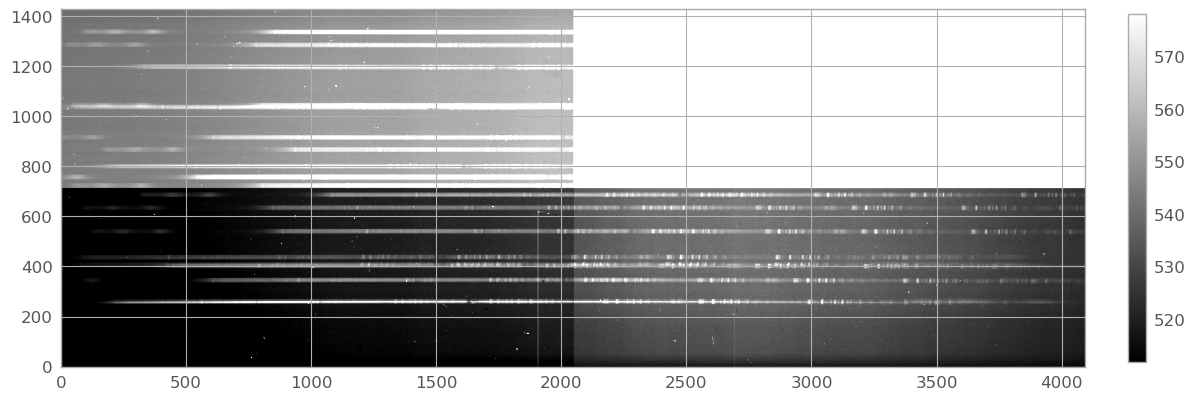

In [12]:
# display setting the limits for the gray scale
median = np.median(spectra)
stddev = np.std(spectra)
z0 = median-stddev
z1 = median+stddev
print(spectra.shape)
SAMOS.display_image(spectra,zmin=z0,zmax=z1)

## FLATS AND BIAS


INFO: Iteration 1: Found 3467 cosmic-ray pixels, Total: 3467 [lacosmic.core]
INFO: Iteration 2: Found 219 cosmic-ray pixels, Total: 3686 [lacosmic.core]
INFO: Iteration 3: Found 68 cosmic-ray pixels, Total: 3754 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 3766 [lacosmic.core]


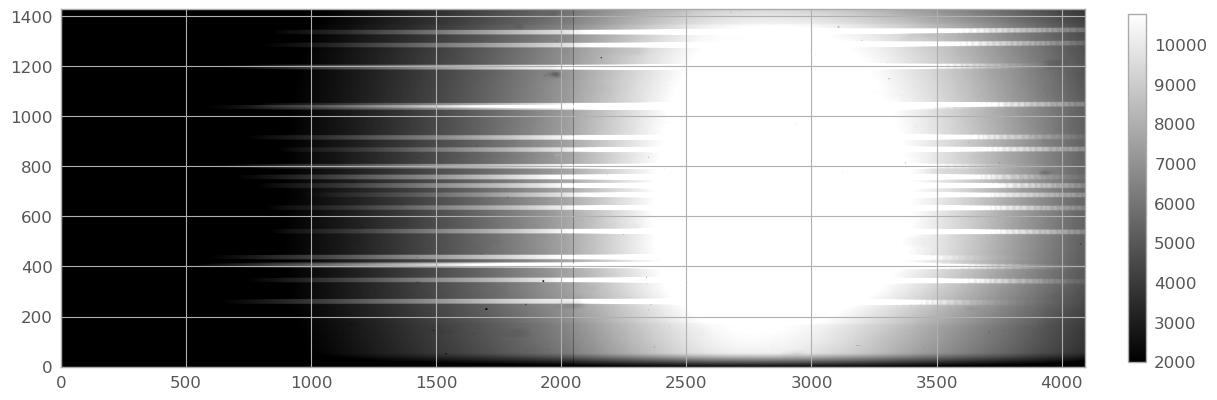

In [14]:
#SET THE FILE NAMES
File_type = "FLAT"
File_NR = '028'
file1  = os.path.join(data_directory_17,'target.'+File_NR+'.fits')
File_NR = '029'
file2  = os.path.join(data_directory_17,'calibration.'+File_NR+'.fits')

#SECOND STEP: READ AND AVERAGE
hdu = SAMOS.read_SAMI_mosaic(file1)
flat1_data = hdu.data
hdu.data = flat1_data

hdu1 = SAMOS.read_SAMI_mosaic(file2)
flat2_data = hdu1.data
hdu1.data = flat2_data
flat = ( flat1_data+flat2_data ) / 2

#SAVE
hdul = fits.HDUList([hdu]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
flat = SAMOS.CR_correct(flat)

#DISPLAY
median = np.median(flat)
stddev = np.std(flat)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat,zmin=z0,zmax=z1)

## Now the BIAS frames

INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]


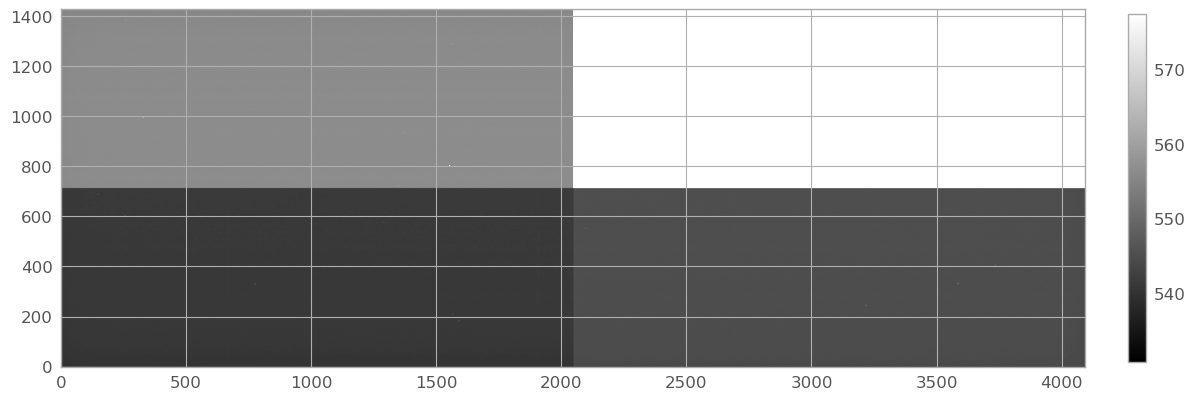

In [16]:
#FIRST STEP: SET THE FILE NAMES
File_type = "BIAS"

File_NR = ['055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074']
biases = np.zeros( (len(File_NR),1428,4094) )
for i in range(len(File_NR)):
    file = os.path.join(data_directory_16,'bias.'+File_NR[i]+'.fits')
    hdu = SAMOS.read_SAMI_mosaic(file)
    biases[i,:,:] = hdu.data
bias = biases.sum(axis=0)/len(File_NR)
bias.shape

#SAVE
hdul = fits.HDUList([hdu]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
bias = SAMOS.CR_correct(bias)

#DISPLAY
median = np.median(bias)
stddev = np.std(bias)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(bias,zmin=z0,zmax=z1)

## SUBTRACT THE BIAS FROM THE FLAT

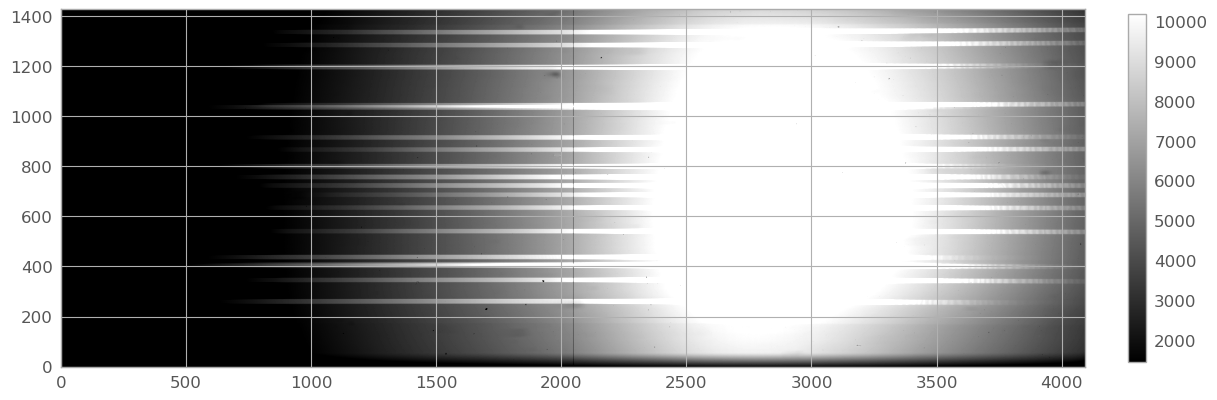

In [18]:
flat_bias = flat - bias

#DISPLAY
median = np.median(flat_bias)
stddev = np.std(flat_bias)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat_bias,zmin=z0,zmax=z1)

## SUBTRACT THE BIAS FROM THE SPECTRA

-15.913302202423534
-0.4866977975765563


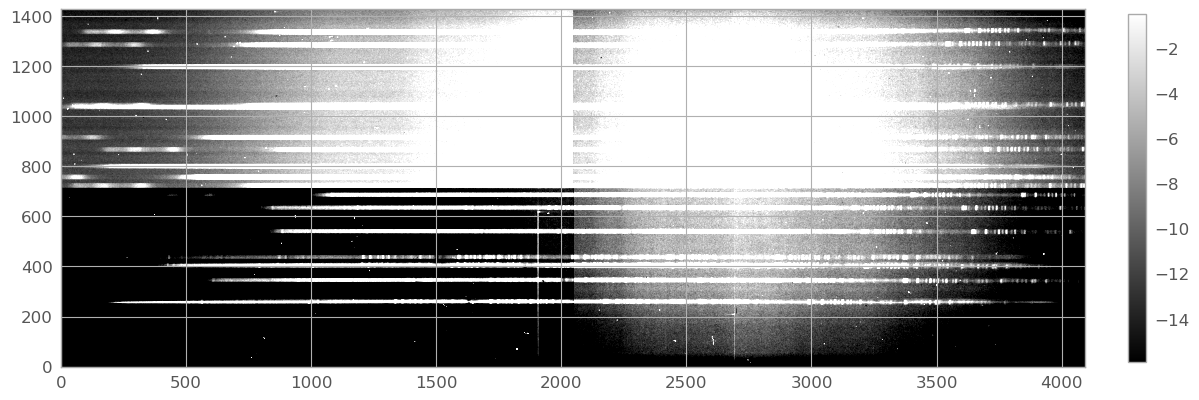

In [20]:
spectra_bias = spectra - bias

#DISPLAY
median = np.median(spectra_bias)
stddev = np.std(spectra_bias)
z0 = median-stddev/2  ; print(z0)
z1 = median+stddev/2  ; print(z1)

SAMOS.display_image(spectra_bias,zmin=z0,zmax=z1)

### There is clearly a problem with the bias, taken on a different night. 
### Also the quartz with all DMD open was taken on the previous night and does not subtract nicely. 
### This makes finding the traces difficult. 

4094
4094 1428
4.0 0.0 4.0 0.0


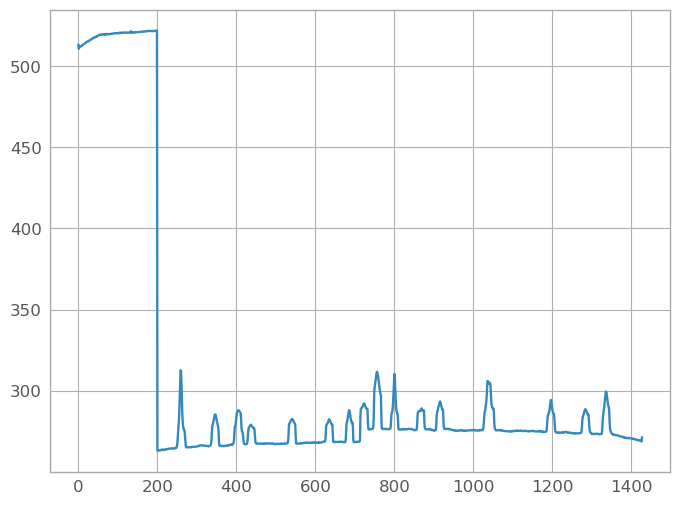

In [22]:
#should we ignore the bias and corect the spectra with their own "bias"
dx = spectra.shape[1] ; print(dx)
dy = spectra.shape[0]
print(dx,dy)
dy2=int(dy/2)
dx2=int(dx/2)

spectra_selfbias = copy.deepcopy(spectra)
spectra_selfbias[200:dy2,:dx2] = spectra[200:dy2,:dx2] - np.median(spectra[200:dy2,:dx2]) 
spectra_selfbias[dy2:,dx2:] = spectra[dy2:,dx2:] - np.median(spectra[dy2:,dx2:]) 
spectra_selfbias[200:dy2,:dx2] = spectra[200:dy2,:dx2] - np.median(spectra[200:dy2,:dx2]) 
spectra_selfbias[dy2:,dx2:] = spectra[dy2:,dx2:] - np.median(spectra[dy2:,dx2:])
print(np.median(spectra_selfbias[:dy2,:dx2]), np.median(spectra_selfbias[dy2:,dx2:]), np.median(spectra_selfbias[:dy2,:dx2]), np.median(spectra_selfbias[dy2:,dx2:]))
s_sb = (spectra_selfbias).mean(axis=1)
plt.plot(s_sb)
plt.show()

## GO WITH ARC LAMP

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241017/calibration.032.fits
INFO: Iteration 1: Found 39996 cosmic-ray pixels, Total: 39996 [lacosmic.core]
INFO: Iteration 2: Found 8653 cosmic-ray pixels, Total: 48649 [lacosmic.core]
INFO: Iteration 3: Found 2712 cosmic-ray pixels, Total: 51361 [lacosmic.core]
INFO: Iteration 4: Found 1368 cosmic-ray pixels, Total: 52729 [lacosmic.core]


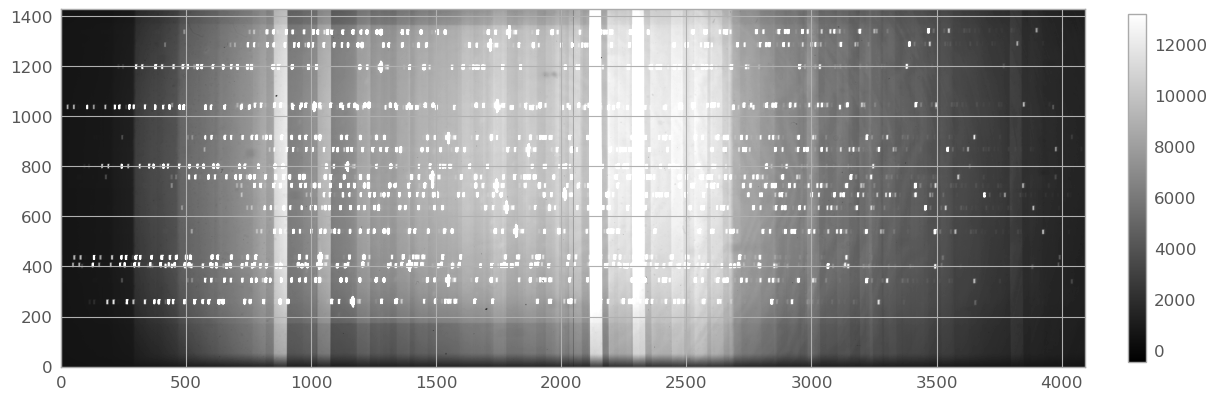

In [24]:
#FIRST STEP: SET THE FILE NAMES
File_type = "ARC"

File_NR = '032'
file  = os.path.join(data_directory_17,'calibration.'+File_NR+'.fits')
print(file)

hdu = SAMOS.read_SAMI_mosaic(file)
arc = hdu.data

#SAVE
hdul = fits.HDUList([hdu]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
arc = SAMOS.CR_correct(arc)

#DISPLAY
median = np.median(arc)
stddev = np.std(arc)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(arc,zmin=z0,zmax=z1)

### FOR THIS ARC WE HAVE ITS OWN "DARK", ILLUMINATION WITH NO DMD OPEN 

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241017/calibration.035.fits
INFO: Iteration 1: Found 4196 cosmic-ray pixels, Total: 4196 [lacosmic.core]
INFO: Iteration 2: Found 137 cosmic-ray pixels, Total: 4333 [lacosmic.core]
INFO: Iteration 3: Found 32 cosmic-ray pixels, Total: 4365 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 4371 [lacosmic.core]


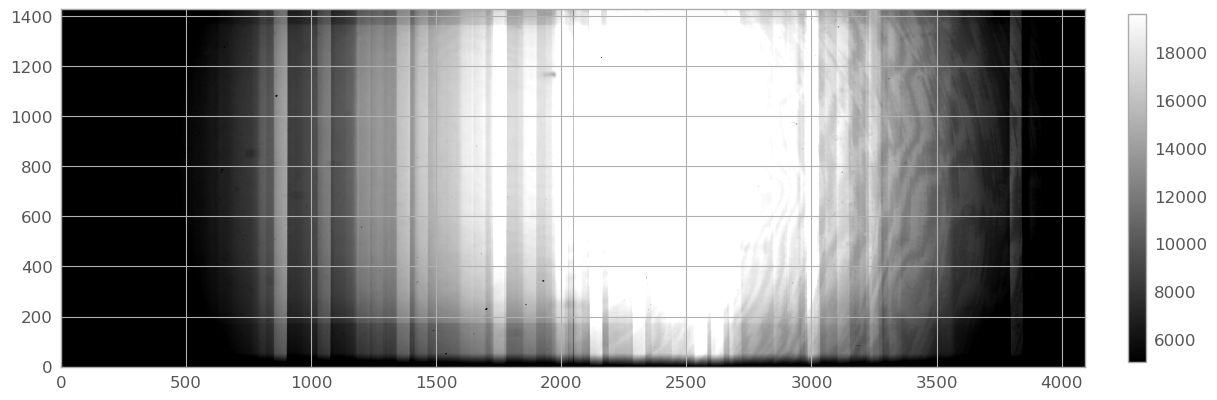

In [26]:
File_type = "ARC_noDMD"

File_NR = '035'
file  = os.path.join(data_directory_17,'calibration.'+File_NR+'.fits')
print(file)

hdu_noDMD = SAMOS.read_SAMI_mosaic(file)
arc_noDMD = hdu_noDMD.data
#SAVE
hdul = fits.HDUList([hdu_noDMD]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
arc_noDMD = SAMOS.CR_correct(arc_noDMD)

#DISPLAY
median = np.median(arc_noDMD)
stddev = np.std(arc_noDMD)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(arc_noDMD,zmin=z0,zmax=z1)

### THE SUBTRACION IS VERY GOOD

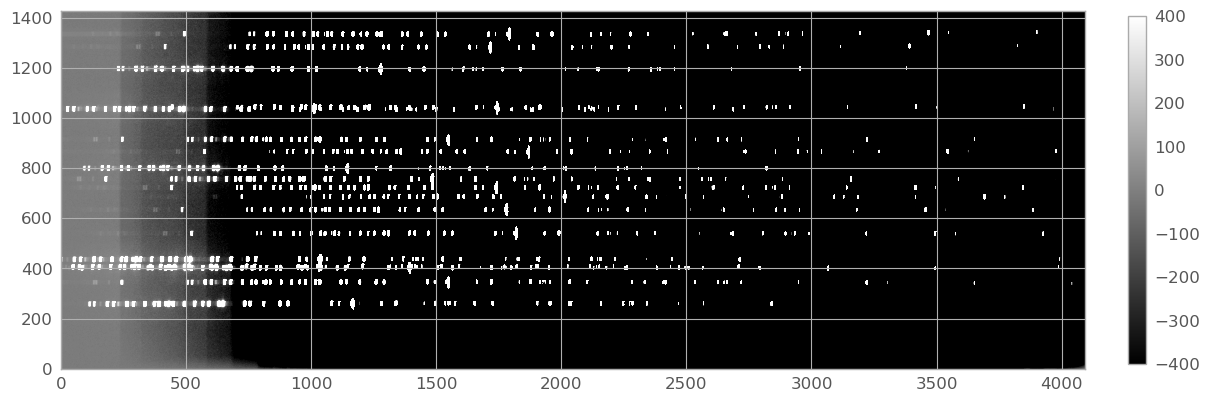

In [28]:
arc_good = arc-arc_noDMD
SAMOS.display_image(arc_good,zmin=-400,zmax=400)

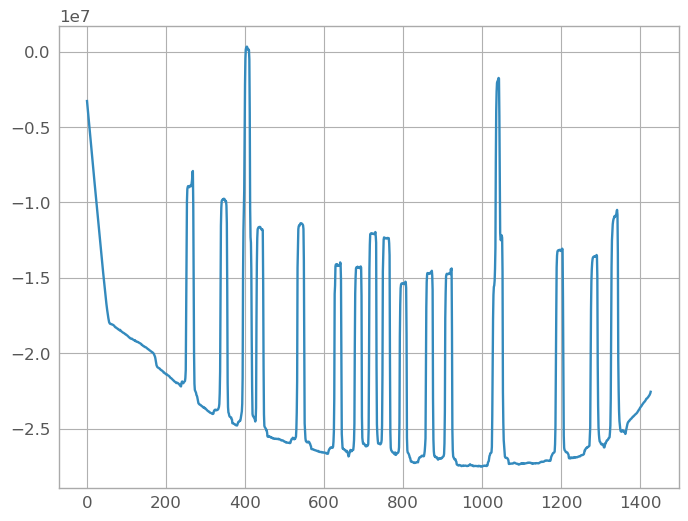

In [29]:
#Check the coadded rows
plt.plot(arc_good.sum(axis=1))

# Nicely sharp. Looks great. We can use the arc to find the traces!

# Find the traces

4094


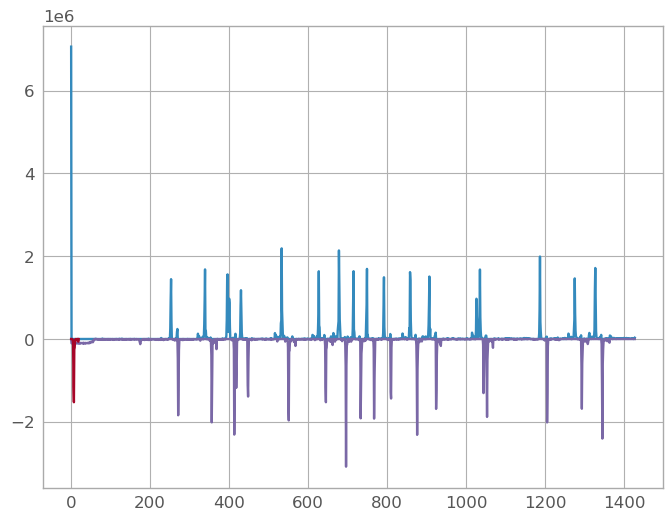

In [32]:
dx = arc_good.shape[1] ; print(dx)
dy = arc_good.shape[0]
mask = np.zeros((dy,dx))
cut = arc_good[:,1500:2500].sum(axis=1)
cut1 = np.roll(cut,+1)
diff=cut-cut1
diff_neg = copy.deepcopy(diff)
diff_neg[diff > 0] =0 
diff_pos = copy.deepcopy(diff)
diff_pos[diff < 0] = 0
#match = diff_pos * (-np.roll(diff_neg,-8))
plt.plot(diff_pos)#[620:640])
plt.plot(diff_neg)#[620:640])
plt.plot(np.roll(diff_neg,-18)[620:640])


plt.show()


# import library
from findpeaks import findpeaks
# Find some peaks using the smoothing parameter.
fp = findpeaks(lookahead=1, interpolate=3)
results = fp.fit(diff_pos)
# Make plot
#fp.plot()
#print(results['df'],results['df']['y'])
peaks_all=results['df']
all_peaks = results['df'][ (results['df']['peak'] == True)] 
slit_up = all_peaks[all_peaks['y'] > 3E5 ]
v_slit_up=slit_up.to_numpy()
#v_slit_up=np.delete(v_slit_up, 16, axis=0)
print(v_slit_up[:,1], len(v_slit_up[:,1]))
slit_up = v_slit_up[:,1]

results = fp.fit(-diff_neg)
# Make plot
#fp.plot()
#print(results['df'],results['df']['y'])
peaks_all=results['df']
all_peaks = results['df'][ (results['df']['peak'] == True)] 
slit_down = all_peaks[all_peaks['y'] > 3E5 ] 
v_slit_down=slit_down.to_numpy()
print(v_slit_down[:,1], len(v_slit_down[:,1]))
slit_down = v_slit_down[:,1]



### Find some peaks using the smoothing parameter.
fp = findpeaks(lookahead=1, interpolate=3) results = fp.fit(diff_pos)

In [35]:
v_slit_up, _ = find_peaks(diff_pos, distance=3,height=3E5)
print(v_slit_up)
v_slit_down, _ = find_peaks(-diff_neg, distance=3,height=3E5)
print(v_slit_down)

[ 253  339  396  400  430  533  627  678  715  749  792  858  907 1026
 1035 1187 1275 1327]
[ 271  356  413  418  448  551  645  696  733  767  810  876  924 1044
 1053 1205 1293 1345]


# ... there is no problem with the pairing of the edges.
# however there are slits too close to each other. Remove some entry...

In [37]:
to_be_removed = []
for i in range (1,len(v_slit_up)):
    #print(v_slit_up[i],v_slit_down[i])
    if (v_slit_down[i-1] > v_slit_up[i]):
        print(v_slit_up[i],v_slit_down[i],"conflict! remove i =",i)
        to_be_removed.append(i)
    else:    
        print(v_slit_up[i],v_slit_down[i])
print(to_be_removed)
v_slit_up=np.delete(v_slit_up, to_be_removed,axis=0) 
v_slit_down=np.delete(v_slit_down, to_be_removed, axis=0)

print("\nCHECK:")
good_slits = []
for i in range (1,len(v_slit_up)):
    print(v_slit_up[i],v_slit_down[i])
    good_slits.append(i)
    

339 356
396 413
400 418 conflict! remove i = 3
430 448
533 551
627 645
678 696
715 733
749 767
792 810
858 876
907 924
1026 1044
1035 1053 conflict! remove i = 14
1187 1205
1275 1293
1327 1345
[3, 14]

CHECK:
339 356
396 413
430 448
533 551
627 645
678 696
715 733
749 767
792 810
858 876
907 924
1026 1044
1187 1205
1275 1293
1327 1345


#v_slit_up=np.delete(v_slit_up, 1, axis=0)
print(v_slit_up[:,1], len(v_slit_up[:,1]))
slit_up = v_slit_up[:,1]

v_slit_down=np.delete(v_slit_down, 5, axis=0)
print(v_slit_down[:,1], len(v_slit_down[:,1]))
slit_down = v_slit_down[:,1]
plt.scatter(v_slit_up[:,1],v_slit_down[:,1],c='blue')

## Good. We can now define the slits

In [40]:
slits=[]
for i in range(len(v_slit_up)):
    slits.append([v_slit_up[i],v_slit_down[i]])
print("we have ",len(slits), "slits")
print("that we can call using e.g. slits[5]:",slits[5])


we have  16 slits
that we can call using e.g. slits[5]: [627, 645]


## BETTER: we also set the limits of the adjacent field edges:

In [42]:
slits=[]
for i in range(len(v_slit_up)):
    #print([slit_up[i],slit_down[i]])
    if i ==0:
        s0 = v_slit_up[i]-10
    else:    
        s0 = np.max([v_slit_down[i-1],v_slit_up[i]-10])
    if  i == len(v_slit_down)-1:
        s1 = v_slit_down[i]+10
    else:
        s1 = np.min([v_slit_up[i+1],v_slit_down[i]+10])
#    print([s0,slit_up[i],slit_down[i],s1])   
    slits.append([s0,v_slit_up[i],v_slit_down[i],s1]) 

print("So the slit[0] is:",slits[2])

So the slit[0] is: [386, 396, 413, 423]


## so basically we have found the traces

## FROM THIS POINT ON ONE COULD PROCEED WITH A LOOP.
## HERE WE DEMONSTRATE PROCEDURE FOR A SINGLE SLIT Nr 11

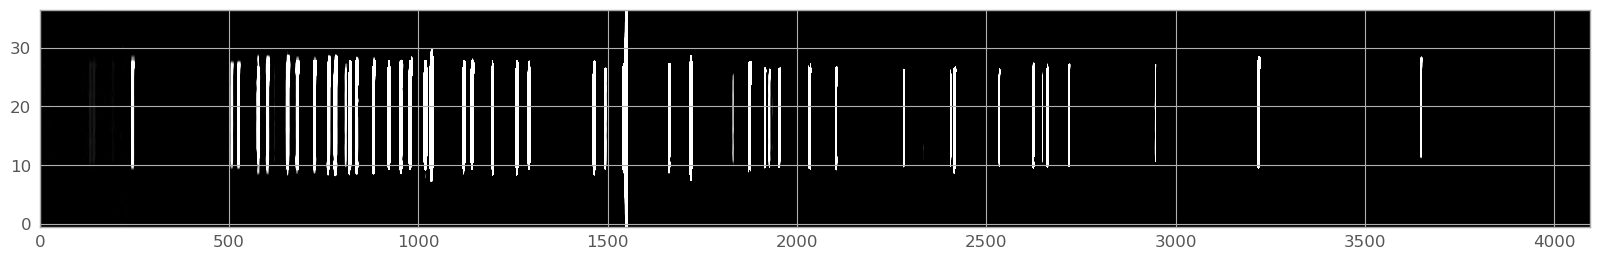

In [489]:
i_slit=11
#arc_good = arc-arc_noDMD
#plt.imshow(image, origin='lower', cmap='gray',vmin=zmin, vmax=zmax)

plt.figure(figsize=(20,3))
plt.imshow(arc_good[slits[i_slit][0]:slits[i_slit][3],:], origin='lower', cmap='gray',vmin=0, vmax=1000,aspect='15.5')
#plt.gca().set_aspect(0.5)
plt.show()

# Plot all slits

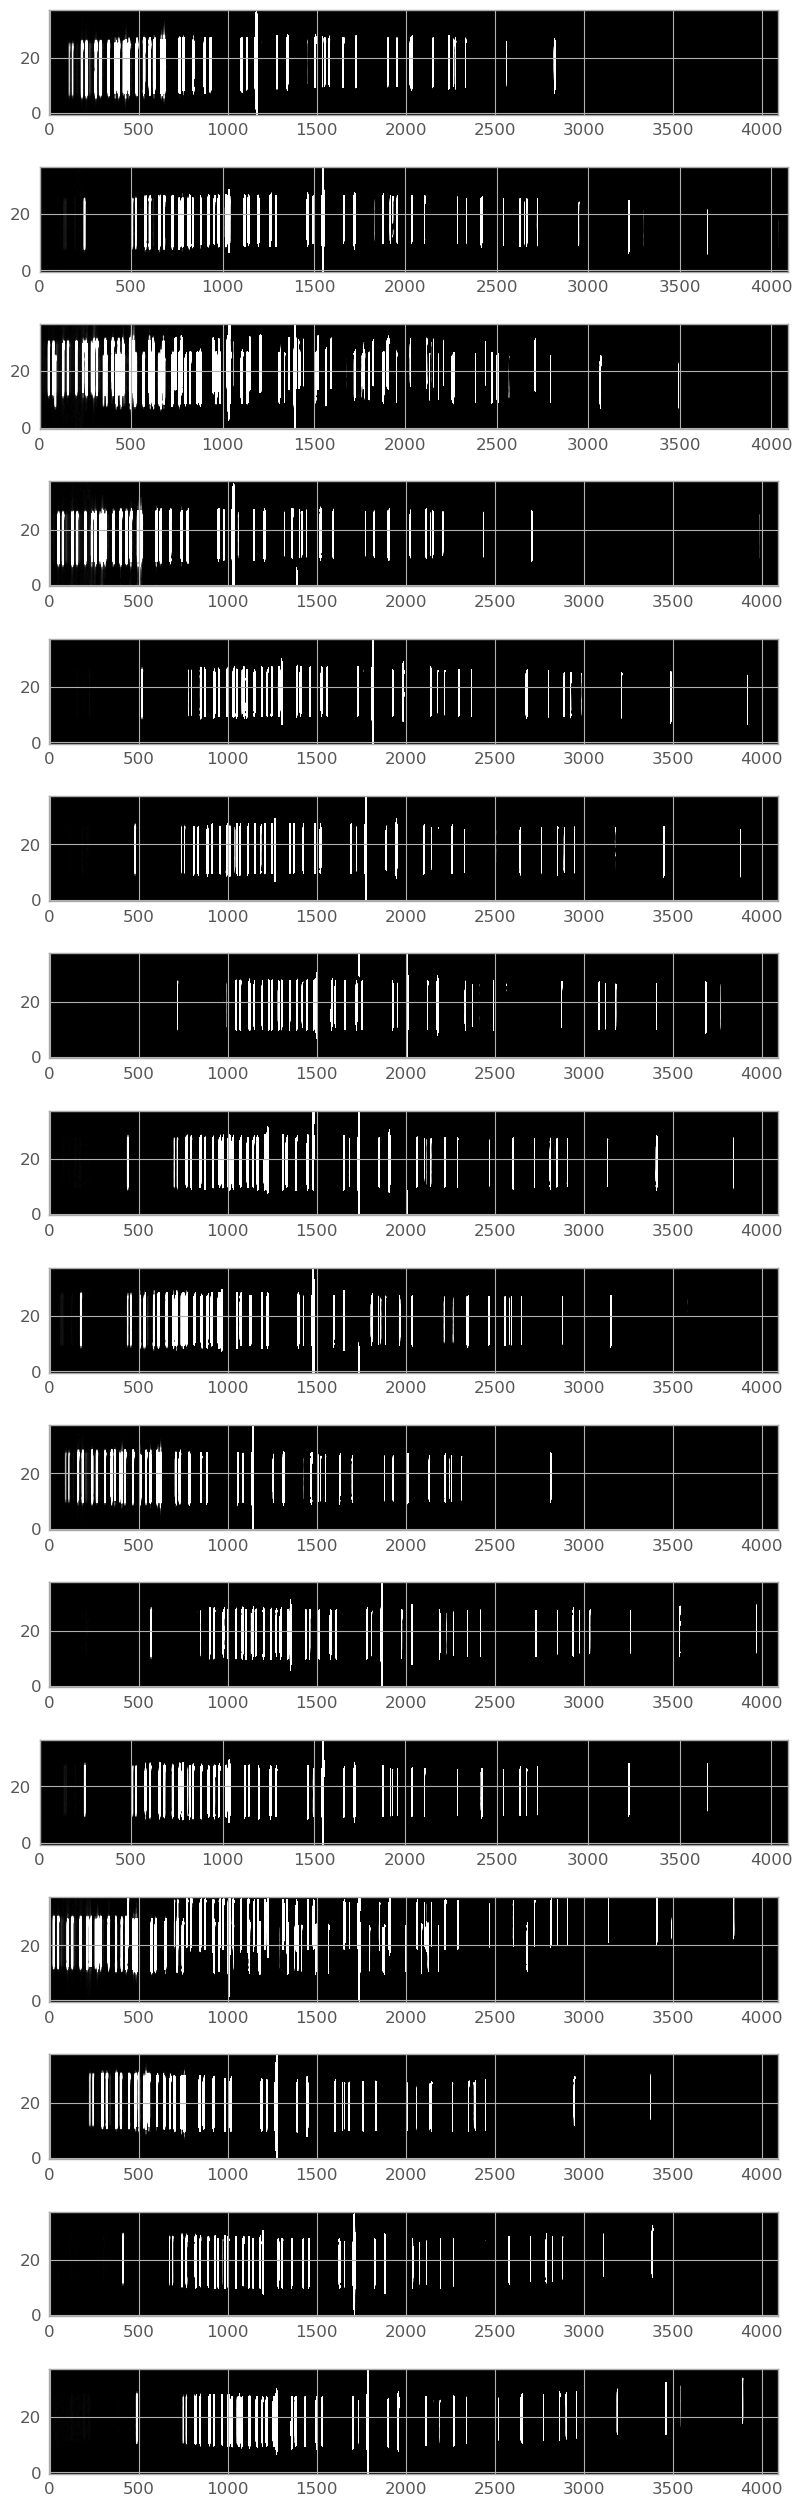

In [491]:
f, axarr = plt.subplots(len(slits),figsize=(20, 32))
#axarr.figure(figsize=(20,30))
for i_s in range(len(slits)):
    axarr[i_s].imshow(arc_good[slits[i_s][0]:slits[i_s][3],:], origin='lower', cmap='gray',vmin=0, vmax=1000,aspect='15.5')
plt.show()

In [492]:
#Repeat with the flats

# Repeat with spectra

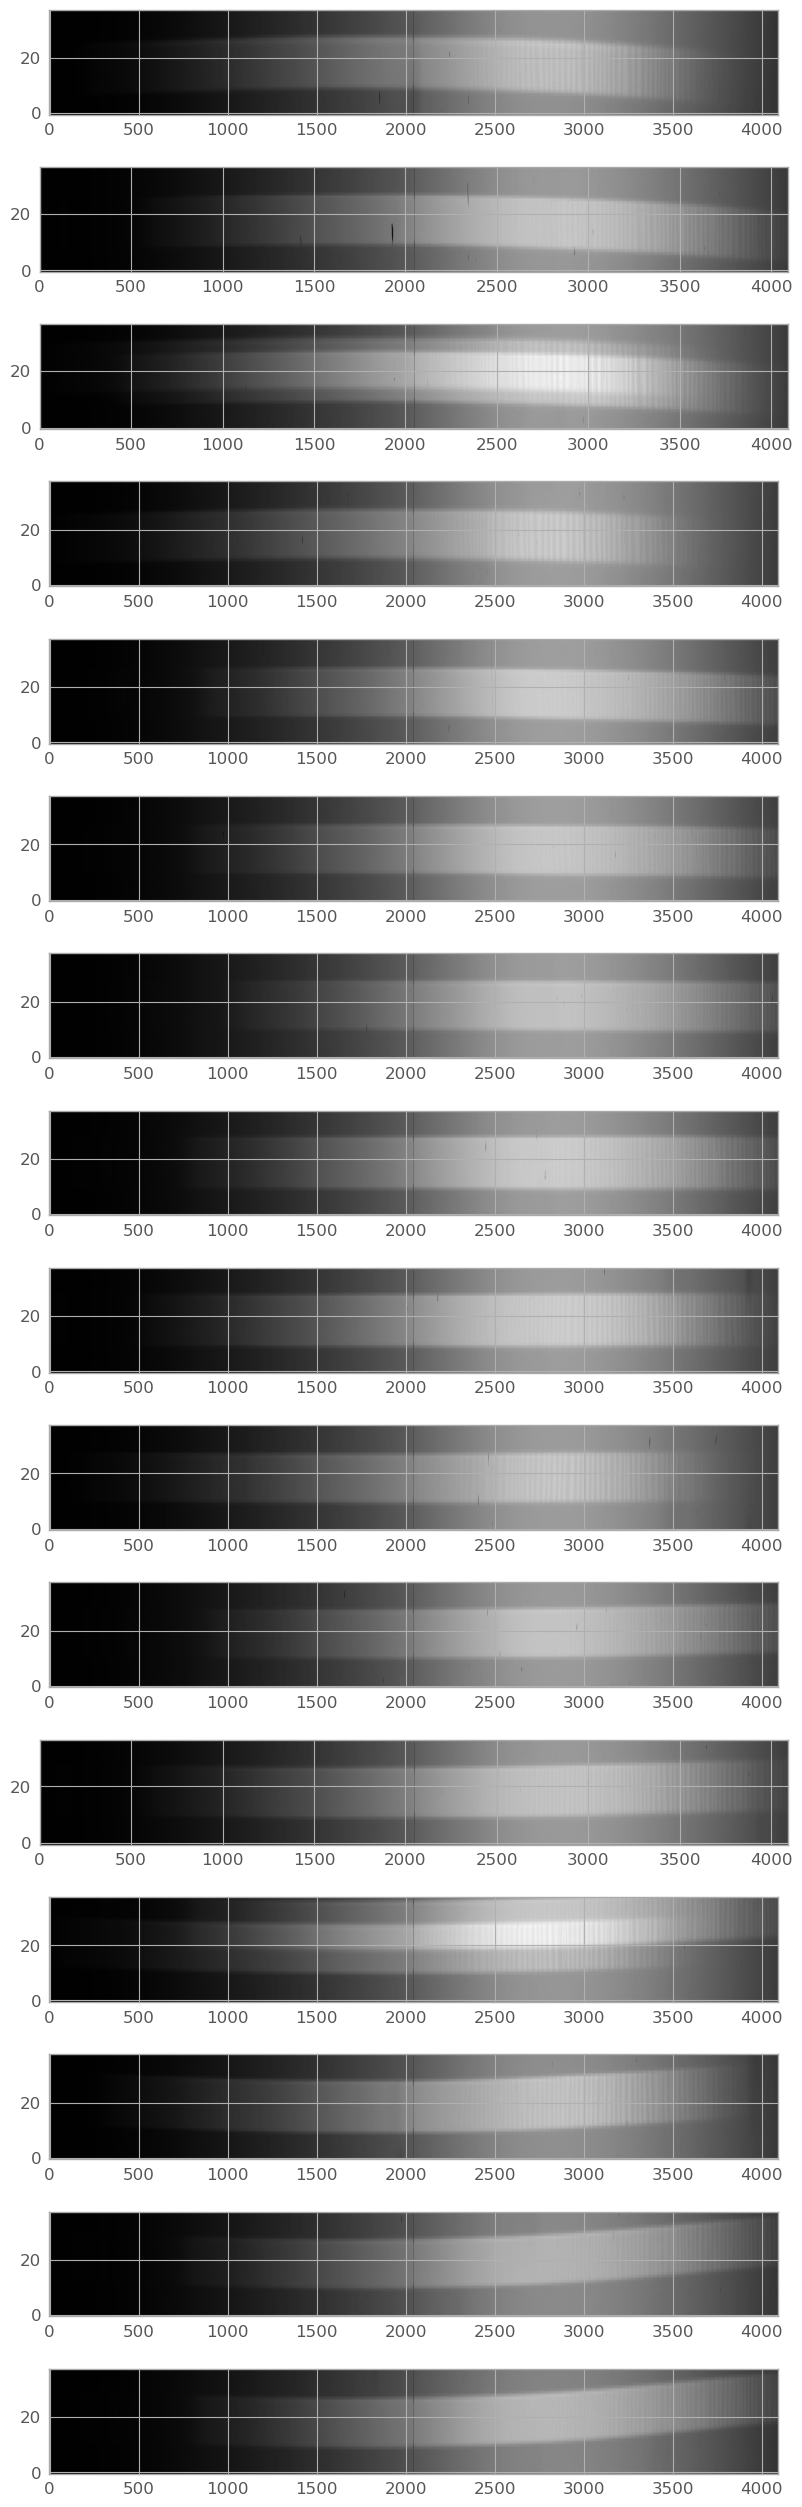

In [494]:
f, axarr = plt.subplots(len(slits),figsize=(20, 32))
#axarr.figure(figsize=(20,30))
for i_s in range(len(slits)):
    axarr[i_s].imshow(flat_bias[slits[i_s][0]:slits[i_s][3],:], origin='lower', cmap='gray',vmin=-100, vmax=20000,aspect='15.5')
plt.show()

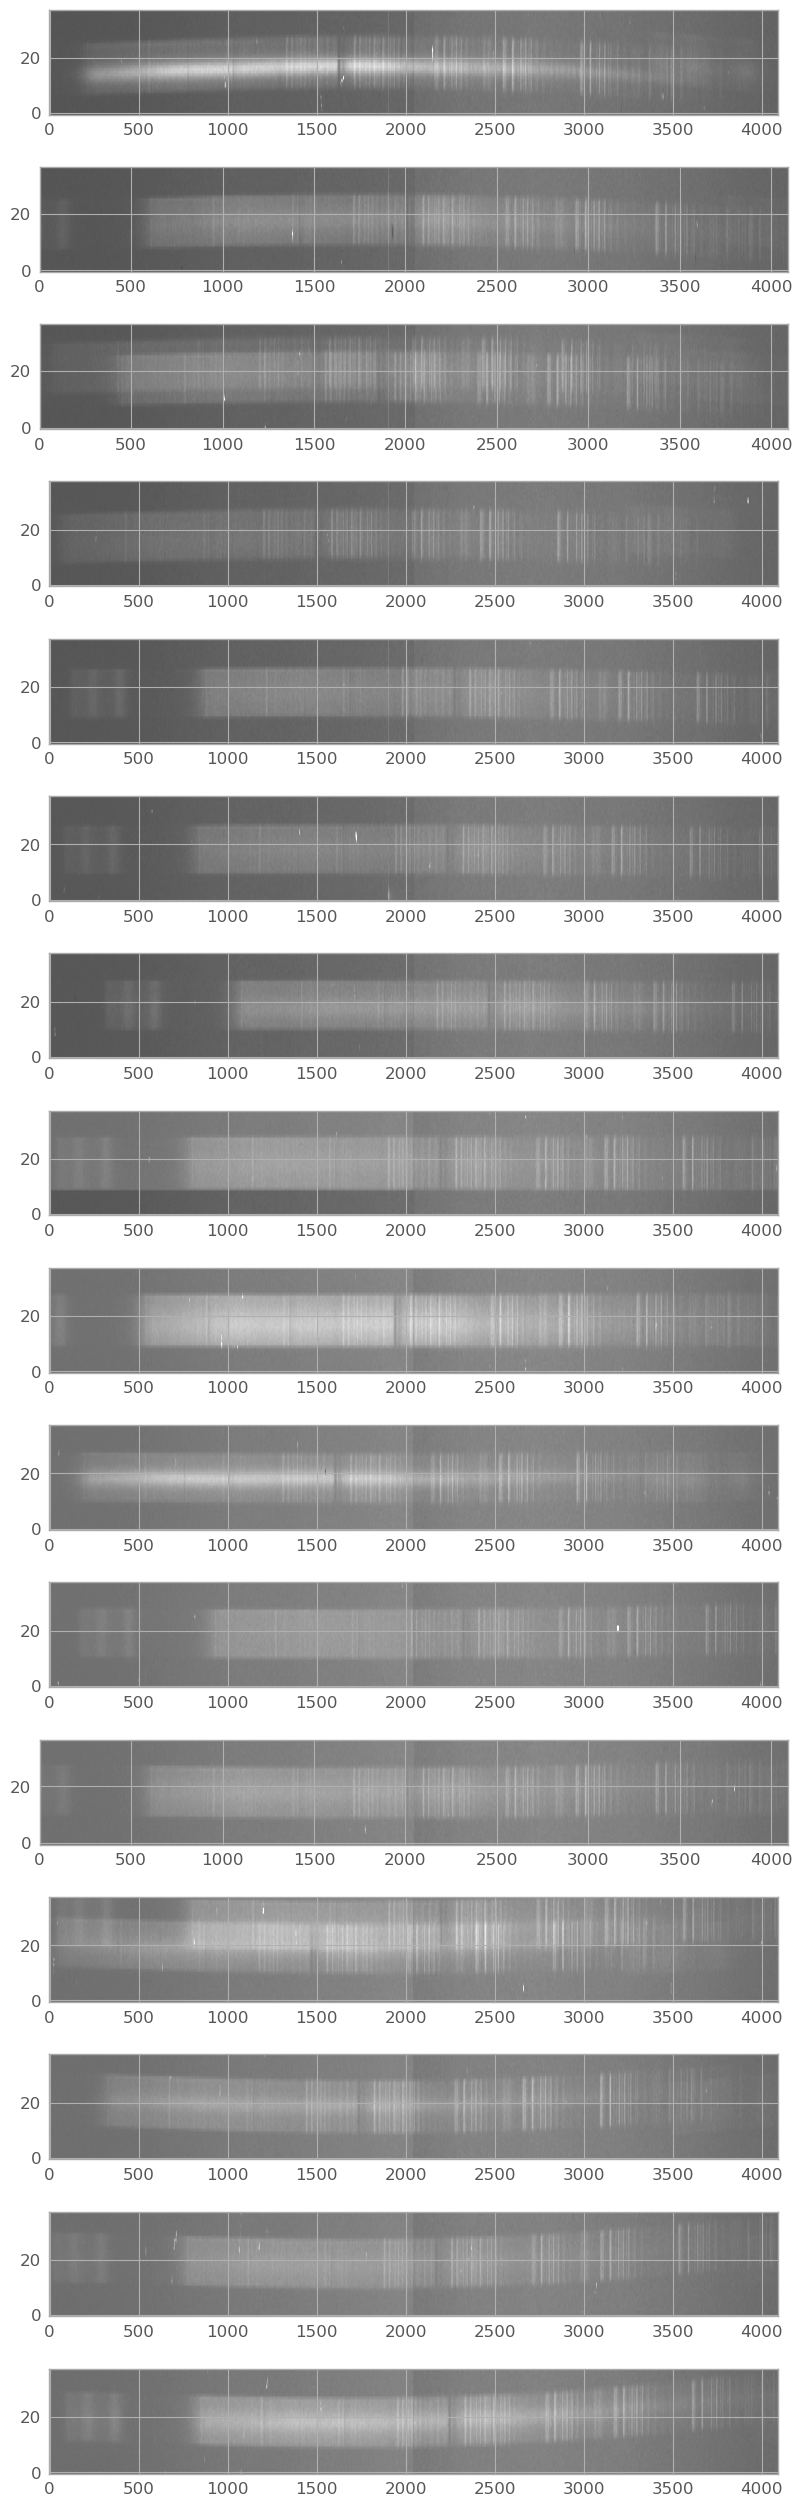

In [495]:
f, axarr = plt.subplots(len(slits),figsize=(20, 32))
#axarr.figure(figsize=(20,30))
for i_s in range(len(slits)):
    axarr[i_s].imshow(spectra_bias[slits[i_s][0]:slits[i_s][3],:], origin='lower', cmap='gray',vmin=-100, vmax=100,aspect='15.5')
plt.show()

# Find the tilt of the spectra

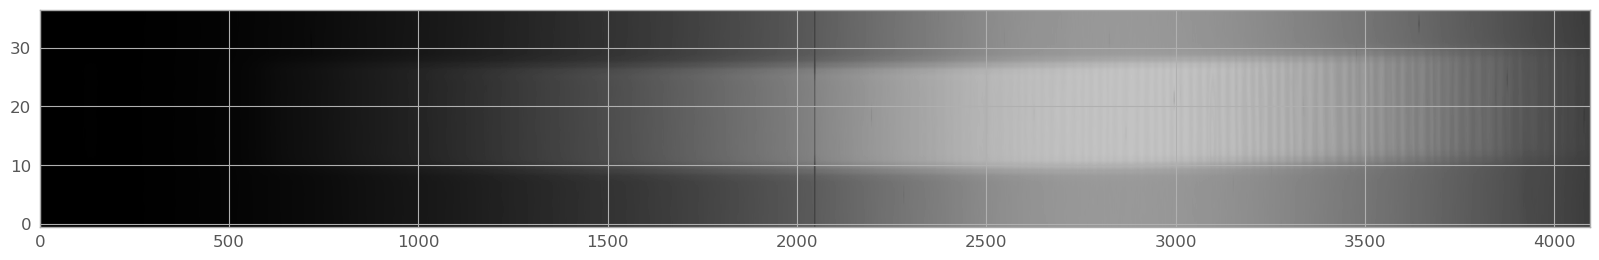

In [497]:
#first we inspect the situation

flat_bias_blur = cv2.GaussianBlur(flat_bias,(3,3), sigmaX=0, sigmaY=0)
plt.figure(figsize=(20,3))
slit = flat_bias_blur[slits[i_slit][0]:slits[i_slit][3],:]
plt.imshow(slit, origin='lower', cmap='gray',vmin=0, vmax=20000,aspect='15.5')
#plt.gca().set_aspect(0.5)
plt.show()


49


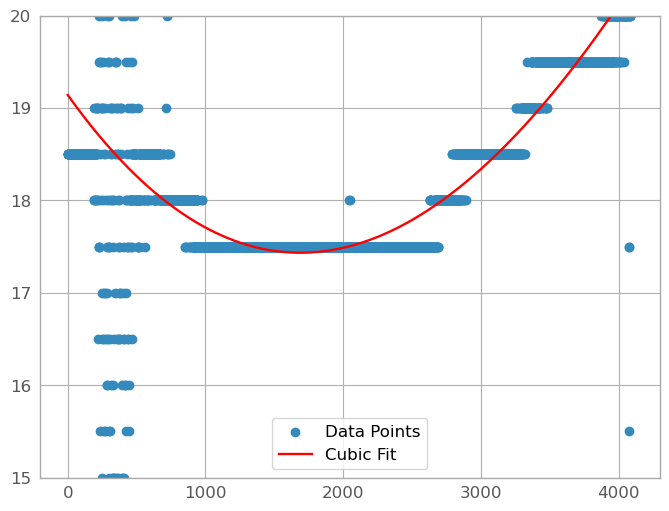

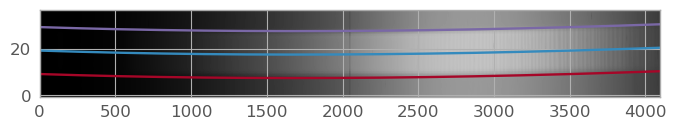

In [498]:
#first we define a function that finds the edges of a 1-d vector
def find_edges(data):
    gradient = [data[i] - data[i-1] for i in range(1, len(data))]
    edges = [i for i, grad in enumerate(gradient) if abs(grad) > threshold]
    return edges

#then the logic is to scan the rectangular area in the x direction, 
#looking for the edges of each column; 
#if there is no edge, skip the column
#if there are multiple edges, pick the maximum and minimum value
#the procedure returns the central value between the extreme edges, i.e. the center of the trace.
xpix=[]
yctr=[]
slit=flat_bias_blur[slits[i_slit][0]:slits[i_slit][3],:]
for i in range(dx):    
    v = slit[:,i]
    threshold = (max(v)-min(v))/5  
    edges=find_edges(v)
    if len(edges) == 0:
        continue
    e0 = edges[0]
    e1 = edges[-1]
    #print(i,e0,e1,np.mean([e0,e1]))
    xpix.append(i)
    yctr.append(np.mean([e0,e1]))

ilen = 0
for i in range(dx-100):
    if np.std(yctr[i:i+100]) == 0:
        imin=i
        ilen+=1
        if ilen == 50:
            break
print(imin)
#print(np.std(yctr[i:i+100]))
    
#next we fit a polynomial, 3rd degree, to the array of centers
coefficients = np.polyfit(xpix[imin:], yctr[imin:], 3)
# Create polynomial function
p = np.poly1d(coefficients)

#plot to check....
plt.ylim(15,20)
plt.scatter(xpix, yctr, label='Data Points')
plt.plot(xpix, p(xpix), label='Cubic Fit', color='red')
plt.legend()
plt.show()
 

# but basically we have the trace.
#Show it with an overlay on the image
fig, ax = plt.subplots()
# Display the image
ax.imshow(flat_bias_blur[slits[i_slit][0]:slits[i_slit][3],:], origin='lower', cmap='gray',vmin=0, vmax=20000,aspect='15.5')
#Display the center trace
x=np.arange(dx)
plt.plot(x, p(x))
#and the edges
below = slits[i_slit][1] - slits[i_slit][0]
above = slits[i_slit][3] - slits[i_slit][2]
plt.plot(x, p(x)+above)
plt.plot(x, p(x)-below)
plt.show()
# Plot the vector

#display_imageslits[i_slit][1]#:i_slit[0][1],1000:1100]

## CREATE THE TWO BINARY MASKS: Illuminated vs. non-illuminated

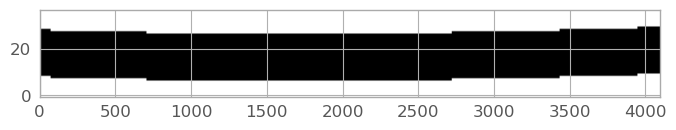

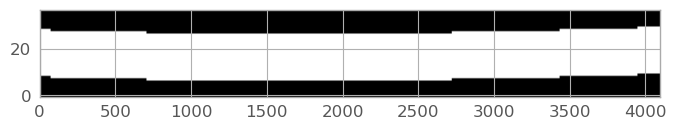

In [500]:
mask_in = slit*0
mask_out = slit*0
for x in range(dx):
    mask_out[0:int(p(x)-below),x]  = 1
    mask_out[int(p(x)+above):,x]  = 1
plt.imshow(mask_out, origin='lower', cmap='gray',aspect='15.5') 
plt.show()

mask_in = 1-mask_out
plt.imshow(mask_in, origin='lower', cmap='gray',aspect='15.5') 
plt.show()

# Extract the flats

(37, 4094)


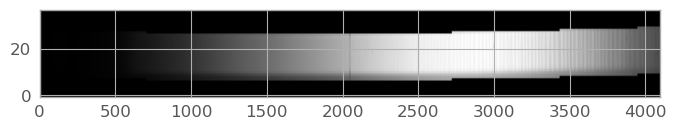

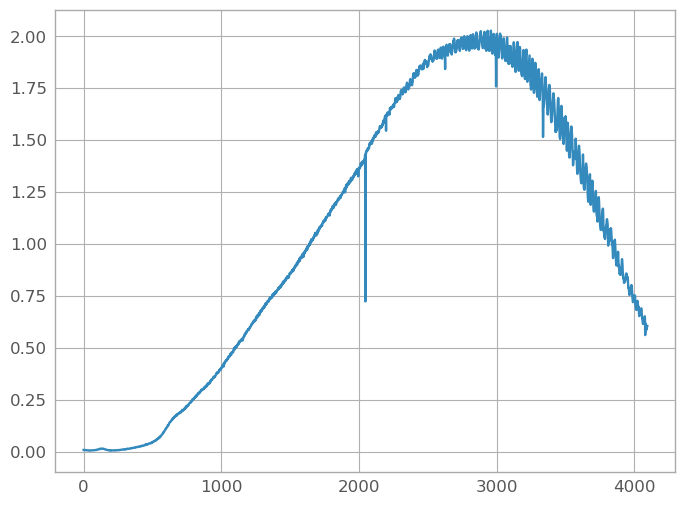

(37, 4094)


In [502]:
flat_bck = slit * mask_out
flat_slit = slit * mask_in
print(flat_slit.shape)
for i in range(dx):
    flat_slit[:,i] = flat_slit[:,i] - np.mean(flat_bck[:,i])
flat_slit *= mask_in   
flat_slit = flat_slit/np.mean(flat_slit[flat_slit != 0])
plt.imshow(flat_slit, origin='lower', cmap='gray',aspect='15.5') 
plt.show()
plt.plot(flat_slit[20,:])
plt.show()
print(flat_slit.shape)

(37, 4094)
(37, 4094) (37, 4094)


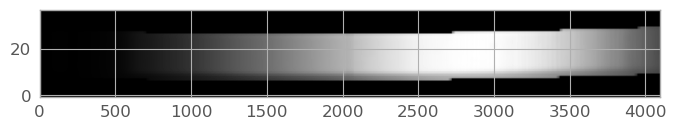

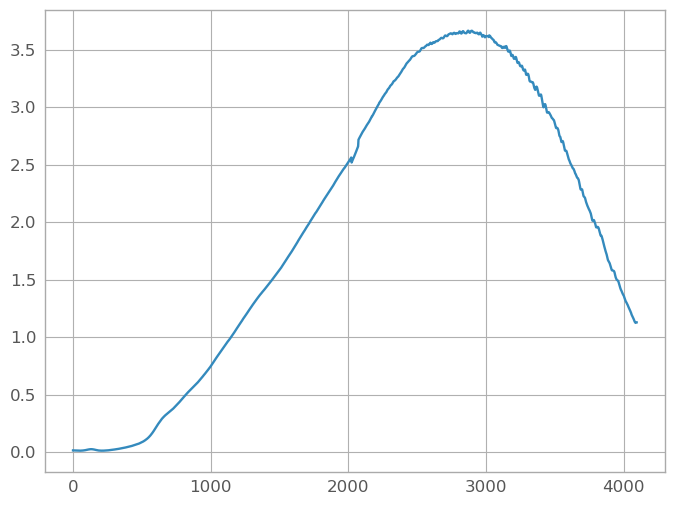

(37, 4094)


In [503]:
# Creating the kernel with numpy 
kernel2 = np.ones((1, 50), np.float32)/50
print(flat_slit.shape)  
# Applying the filter 
flat_slit_smooth = cv2.filter2D(src=flat_slit, ddepth=-1, kernel=kernel2) 
print(flat_slit.shape,flat_slit_smooth.shape)

#flat_slit_smooth *= mask_in   
flat_slit_smooth = flat_slit_smooth/np.mean(flat_slit_smooth[flat_slit_smooth != 0])
flat_slit_smooth *= mask_in
plt.imshow(flat_slit_smooth, origin='lower', cmap='gray',aspect='15.5') 
plt.show()
plt.plot(flat_slit_smooth[20,:])
plt.show()
print(flat_slit_smooth.shape)

### Flat field the image

(37, 4094)


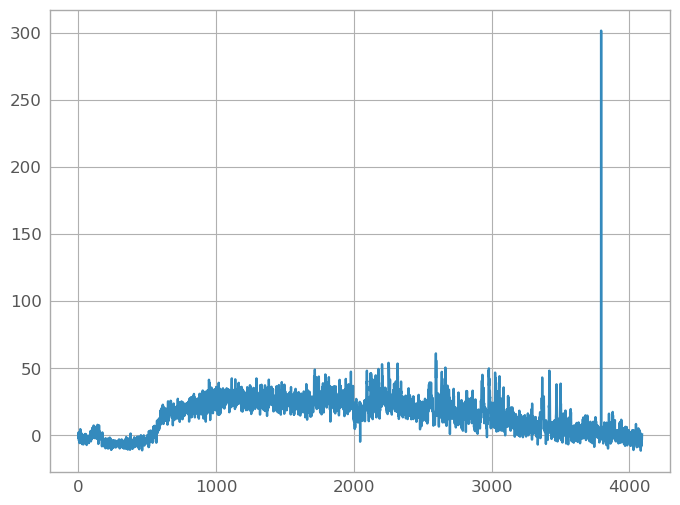

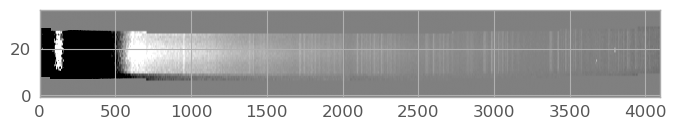

In [505]:
spectra_slit  = spectra_bias[slits[i_slit][0]:slits[i_slit][3],:] * mask_in
spectra_bck = spectra_bias[slits[i_slit][0]:slits[i_slit][3],:] * mask_out
for i in range(dx):
    spectra_slit[:,i] = spectra_slit[:,i] - np.mean(spectra_bck[:,i])
spectra_slit *= mask_in   
print(spectra_slit.shape)

plt.plot(spectra_slit[20,:])
plt.show()
spectra_slit_ff = spectra_slit / flat_slit_smooth
spectra_slit_ff = np.nan_to_num(spectra_slit_ff,posinf=0, neginf=0)
#print(spectra_slit_ff)
plt.imshow(spectra_slit_ff, origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()

# RECTIFY THE SPECTRUM

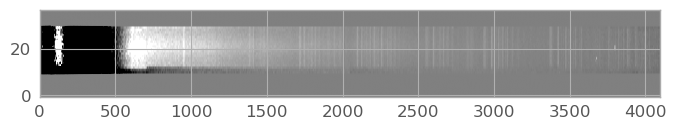

In [507]:
spectra_slit_ff_rect = spectra_slit_ff * 0
for i in range(dx):
    spectra_slit_ff_rect[:,i] = np.roll(spectra_slit_ff[:,i],-int(p(i))+20)
plt.imshow(spectra_slit_ff_rect,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()

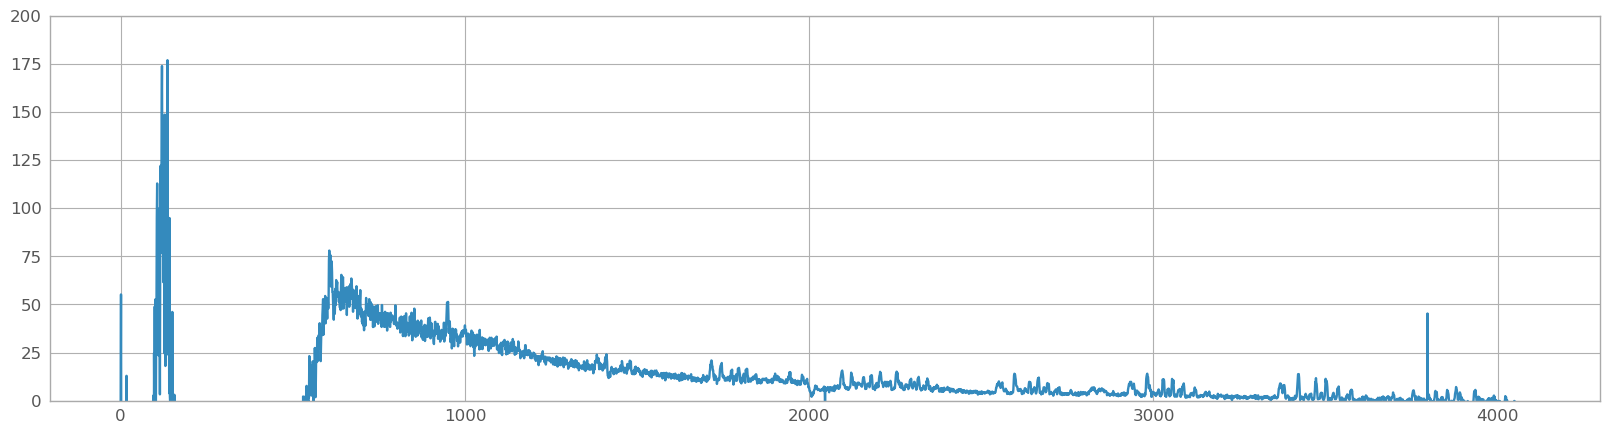

In [508]:
spectrum_1d = spectra_slit_ff[17:25,:].mean(axis=0)
plt.figure(figsize=(20,5))
plt.ylim([0,200])
plt.plot(spectrum_1d) 
plt.show()


# SUBTRACT SKY

In [ ]:
spectra_slit_ff_rect_OH = spectra_slit_ff_rect 
for i in range(dx):#2000,2001):
    #print(i)
    v=spectra_slit_ff_rect[:,i]
    v=v[v != 0]
    #print(v)
    vs = np.sort(v)
    #print(vs)
    mmm = np.median(vs[3:7])
    #print(mmm)
    spectra_slit_ff_rect_OH[:,i] = spectra_slit_ff_rect[:,i] - mmm
    #print(spectra_slit_ff_rect_OH[:,i])
plt.imshow(spectra_slit_ff_rect_OH,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()

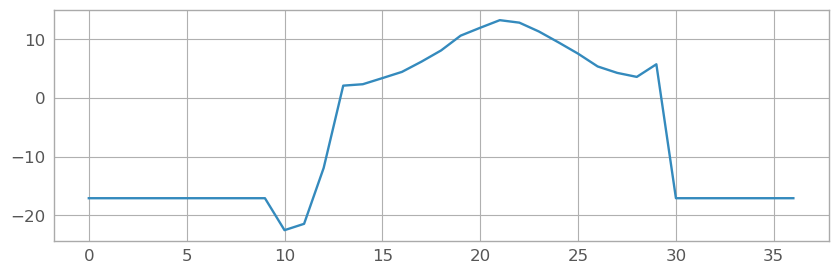

In [510]:
spectrum_1d = spectra_slit_ff_rect_OH[:,800:1500].mean(axis=1)
plt.figure(figsize=(10,3))
#plt.ylim([0,200])
plt.plot(spectrum_1d) 
plt.show()


### Look at the 1-d spectrum


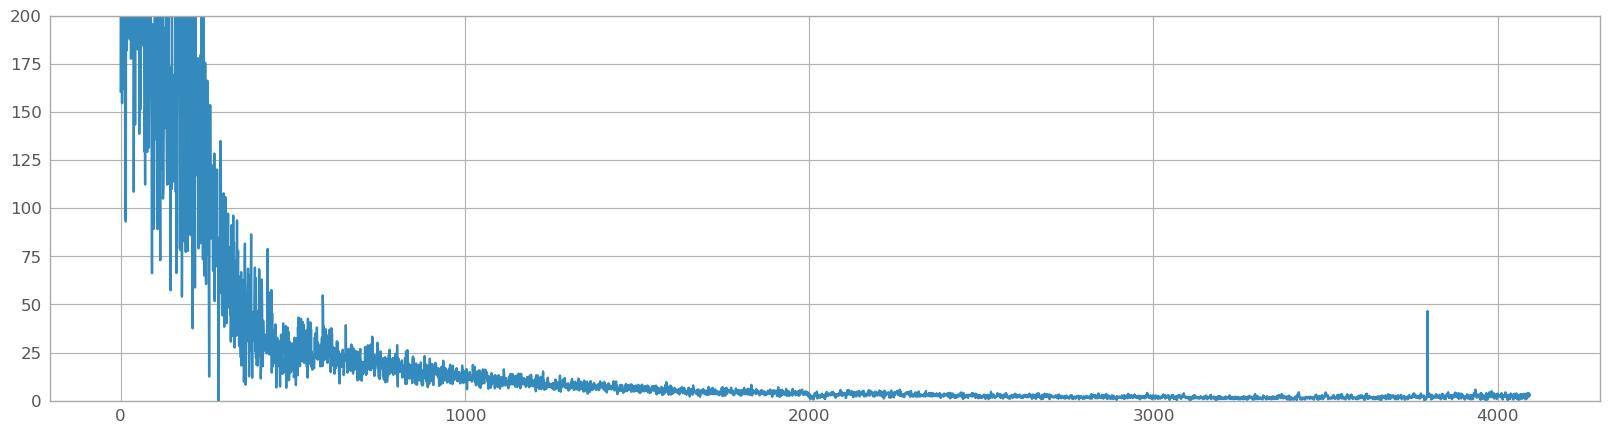

In [512]:
spectrum_1d = spectra_slit_ff_rect_OH[17:25,:].mean(axis=0)
plt.figure(figsize=(20,5))
plt.ylim([0,200])
plt.plot(spectrum_1d) 
plt.show()


### LINE CALIBRATION

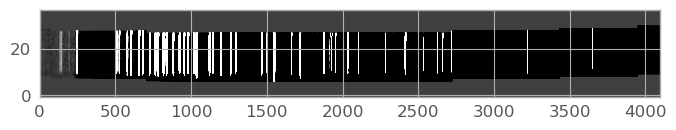

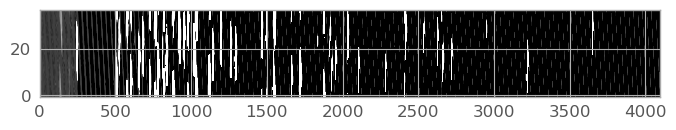

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
         x             y   labx  valley  peak
242    242   1279.297297   43.0   False  True
246    246   1277.864865   44.0   False  True
504    504    653.945946   92.0   False  True
509    509    541.972973   93.0   False  True
522    522    938.864865   95.0   False  True
527    527    704.000000   96.0   False  True
576    576   8618.972973  103.0   False  True
600    600   9165.297297  106.0   False  True
649    649    370.756757  112.0   False  True
654    654  22498.729730  113.0   False  True
680    680   6144.729730  116.0   False  True
725    725   7355.432432  122.0   False  True
762    762  21267.702703  126.0   False  True
778    778  26346.837838  127.0   False  True
782    782  26265.810811  128.0   False  True
808    808    527.729730  130.0   False  True
818    818  25188.729730  131.0   False  True
836    836  20272.648649  132.0   False  True
880    880  19354.216216  137.0   False  True
920    920  

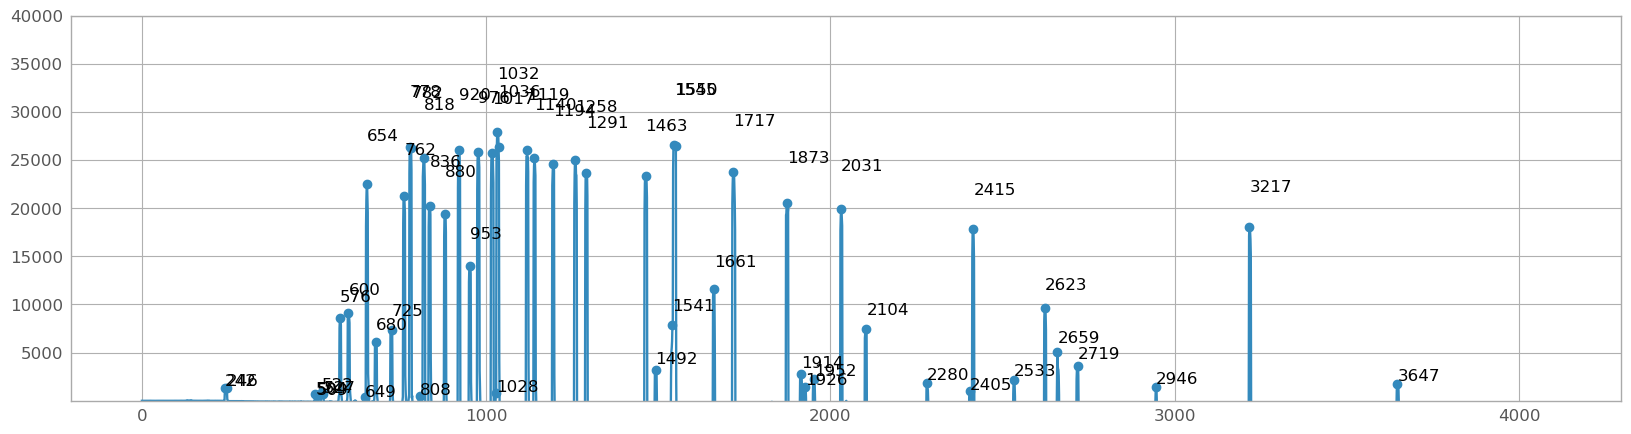

In [562]:
arc_good_slit  = arc_good[slits[i_slit][0]:slits[i_slit][3],:] * mask_in
arc_good_bck = arc_good[slits[i_slit][0]:slits[i_slit][3],:] * mask_out
plt.imshow(arc_good_slit, origin='lower', cmap='gray',vmin=-50, vmax=150,aspect='15.5') 
plt.show()

arc_good_rect = arc_good_slit * 0
for i in range(dx):
    arc_good_rect[:,i] = np.roll(arc_good_slit[:,i],-int(p(i))+20)
plt.imshow(arc_good_rect,origin='lower', cmap='gray',vmin=-50, vmax=150,aspect='15.5') 
plt.show()

plt.figure(figsize=(20,5))
#plt.yscale('log')
plt.ylim([10,4e4])
plt.plot(arc_good_rect.mean(axis=0))


#find the lines
#from scipy.signal import find_peaks 
import findpeaks
fp = findpeaks.findpeaks(lookahead=1)
#results = fp.fit(vector)
lines_df = fp.fit(arc_good_rect.mean(axis=0))
lines= lines_df['df'][ (lines_df['df']['peak'] == True)] 
lll = lines[lines['y'] > 100 ]
print(lll)
lll_np=lll.to_numpy()
xxx = lll.x.to_numpy()
yyy = lll.y.to_numpy()
#v_slit_up=np.delete(v_slit_up, 16, axis=0)
#print(lll_np[:,1], len(lll_np[:,1]))
#print(lines)
ax = fig.add_subplot(1, 1, 1)
plt.scatter(xxx,yyy)
for i in range(len(xxx)):
    plt.text(xxx[i], yyy[i]*1.2, str(xxx[i]), fontsize = 12)
plt.show()


#Ar_lines = np.array([696.54, 706.72, 714.70, 727.20, 738.40, 750.39, 763.51, 772.38, 794.82, 811.53, 826.45, 842.47, 852.14, 866.80, 912.30, 922.50])
#Hg_lines = [253.65, 296.73, 302.15, 313.16, 334.15,	404.66, 365.02, 407.78, 435.83,	546.07,	576.96,	579.07]
#Ne_lines = 
#plt.scatter(3*Ar_lines-100,np.ones(int(len(Ar_lines))))
#plt.show()

Linear Fit Coefficients: [-3.51484406e-09  3.32171867e-05  1.15857280e+00  5.17409251e+03]
5751.7324127671145


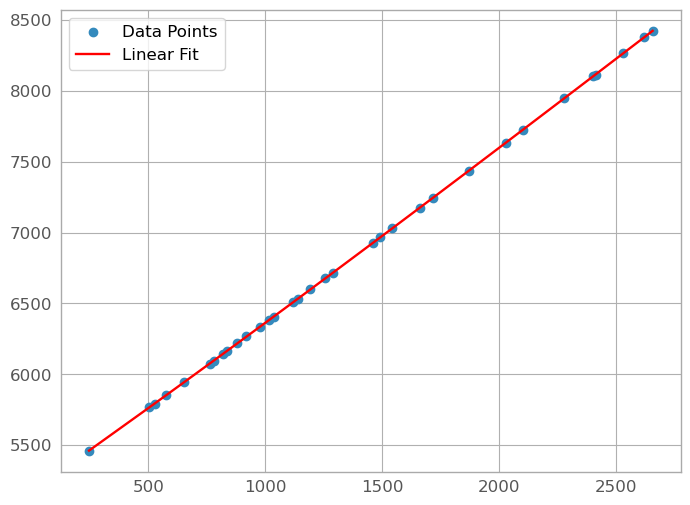

In [515]:
#HgArNe_pix = [1119, 1140, 1194, 1258, 1291, 1463, 1492, 1545, 2031, 2104, 2280, 2405, 2533,2623, 2659]#,2719]
#HgArNe_lam = [6506, 6532, 6508, 6532, 6717, 6929, 6963, 7032, 7635, 7724, 7948, 8103, 8264,8377, 8424]#,8424]
HgArNe_pix = [246, 504, 527,  576,  654,  762,  782,  818,  836,  880,  920,  976, 1017, 1036, 1119, 1140, 1194, 1258, 1291, 1463, 1492, 1545, 1661, 1717, 1873, 2031, 2104, 2280, 2405, 2415, 2533,2623, 2659]#,2719]
HgArNe_lam = [5460.7500,
              5769.6100,
              5790.6700, 
              5852.4879, 
              5944.8342, 
              6074.3377, 
              6096.1631, 
              6143.5939, 
              6163.5939, 
              6217.2812, 
              6266.4950, 
              6334.4278, 
              6382.9917, 
              6402.2480, 
              6506.5281, 
              6532.8822, 
              6598.9529, 
              6678.2762, 
              6717.0430, 
              6929.4673, 
              6965.4310, 
              7032.4131, 
              7173.9381,
              7245.1666,
              7435.3680,
              7635.1060, 
              7724.2070, 
              7948.1760, 
              8103.6930, 
              8115.3110,
              8264.5220,
              8377.6080, 
              8424.6480]#,8424]
plt.scatter(HgArNe_pix,HgArNe_lam, label='Data Points')

coefficients = np.polyfit(HgArNe_pix,HgArNe_lam, 3)
print("Linear Fit Coefficients:", coefficients)

# Create polynomial function
p = np.poly1d(coefficients)

#fishing for the lines we have used...
print(p(492))

plt.plot(HgArNe_pix, p(HgArNe_pix), label='Linear Fit', color='red')
plt.legend()
plt.show()



[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


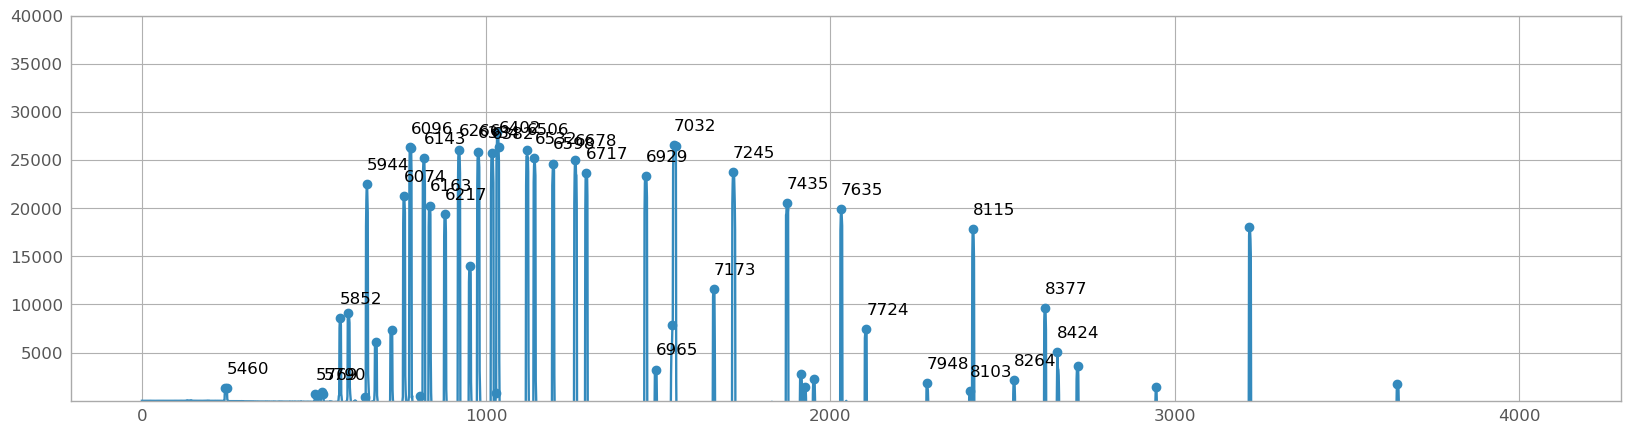

In [664]:
plt.figure(figsize=(20,5))
#plt.yscale('log')
plt.ylim([10,4e4])
plt.plot(arc_good_rect.mean(axis=0))


#find the lines
from scipy.signal import find_peaks 
import findpeaks
fp = findpeaks.findpeaks(lookahead=1)
#results = fp.fit(vector)
lines_df = fp.fit(arc_good_rect.mean(axis=0))
lines= lines_df['df'][ (lines_df['df']['peak'] == True)] 
lll = lines[lines['y'] > 100 ]
xxx = lll.x.to_numpy()
yyy = lll.y.to_numpy()
#print(lll)
#lll_np=lll.to_numpy()
#v_slit_up=np.delete(v_slit_up, 16, axis=0)
#print(lll_np[:,1], len(lll_np[:,1]))
#print(lines)
ax = fig.add_subplot(1, 1, 1)
plt.scatter(xxx,yyy)
counter=0
for i in HgArNe_pix:
    z = lll.y[lll.x == i]
    z1=z.to_numpy()[0]
    plt.text(int(i), np.squeeze(z1)+1.5E3, str(int(HgArNe_lam[counter])), fontsize = 12)
    counter+=1
plt.show()

## FINALLY REDUCED SPECTRUM

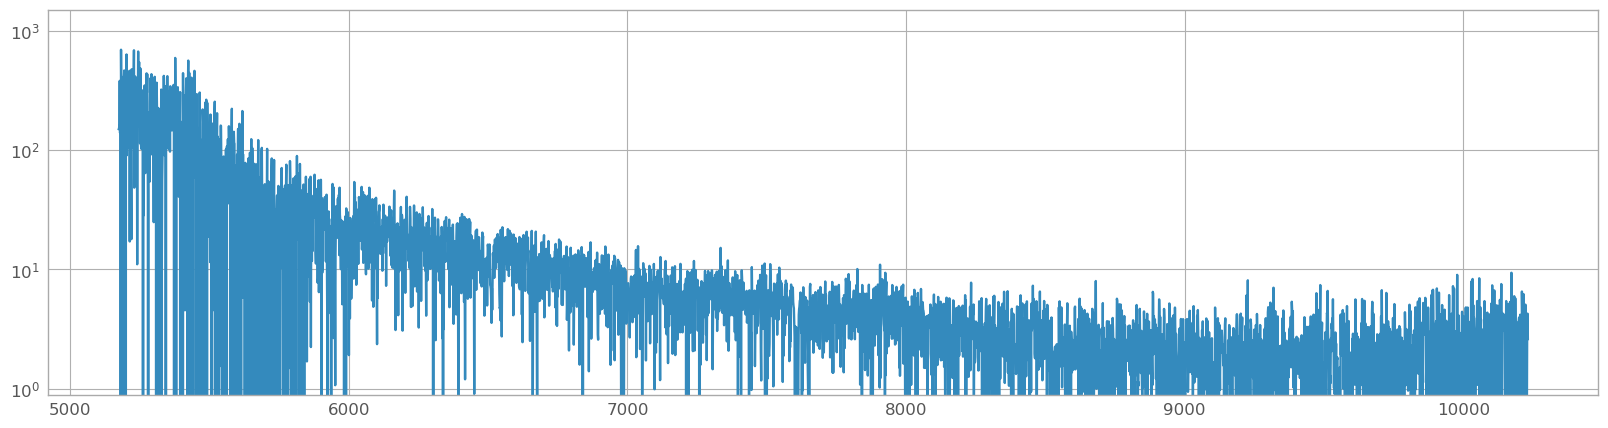

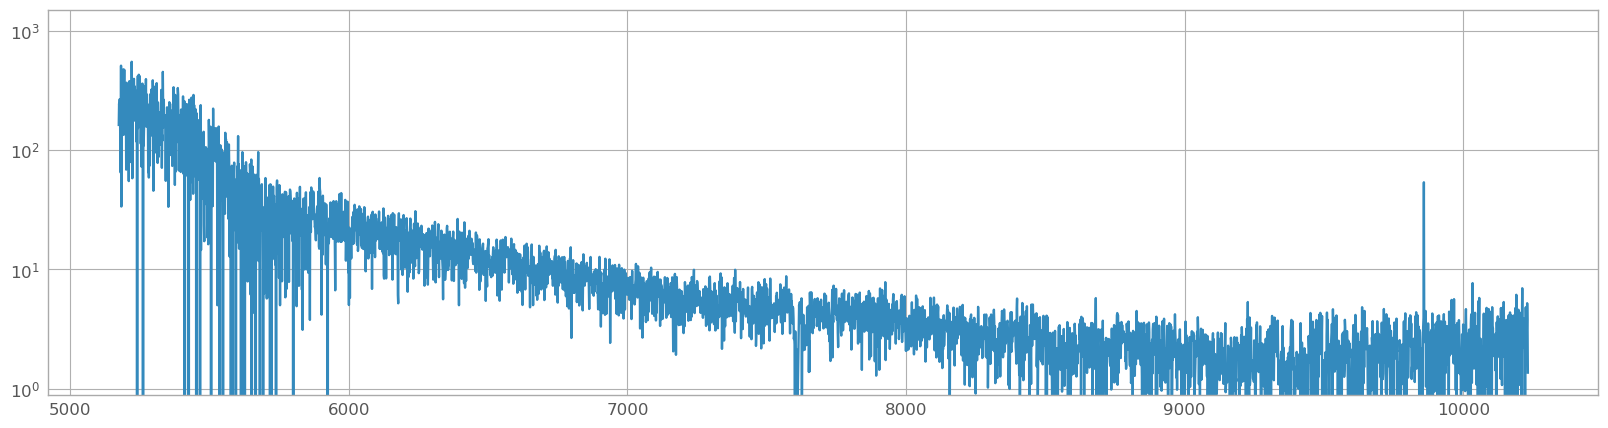

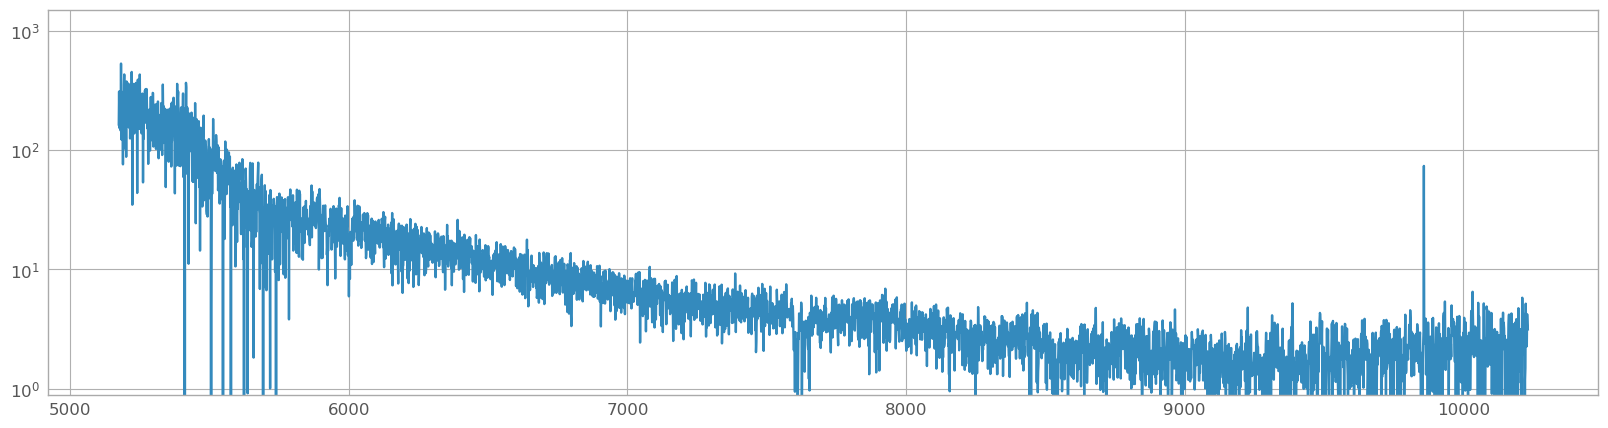

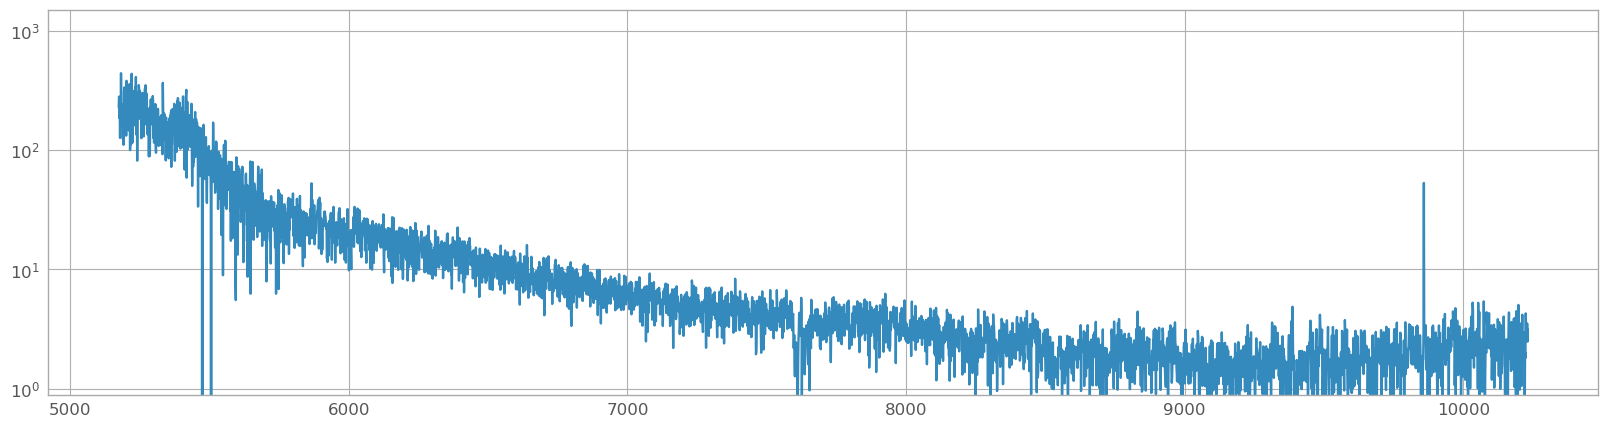

In [672]:
x=np.arange(dx)
wl = p(x)
xc = 20#(slits[i][2]+slits[i][1])/2.
#spectrum_1d = spectra_slit_ff_rect_OH[17:25,:].mean(axis=0)
for dist in range(4):
    plt.figure(figsize=(20,5))
    plt.yscale('log')
    plt.ylim([0,1500])
    spectrum_1d = spectra_slit_ff_rect_OH[22-dist:23+dist,:].mean(axis=0)
    plt.plot(wl,spectrum_1d) 
    plt.show()

# GET THE SPECTRA FOR THE OTHER LAMPS
# LEFT AS AN EXERCISE


In [520]:
#inverse solution
coefficients_1 = np.polyfit(HgArNe_lam,HgArNe_pix, 3)
print("Linear Fit Coefficients:", coefficients_1)

# Create polynomial function
p_1 = np.poly1d(coefficients_1)


HgAr_lam= [6965.431, 7067.218, 7147.042, 7272.936, 7383.980, 7503.869, 7514.652, 7635.106, 7723.761, 7948.176,  8006.157, 8014.786, 8103.6930, 8115.3110]
print(p_1(HgAr_lam))

Linear Fit Coefficients: [ 1.76534737e-09 -4.63696687e-05  1.19920679e+00 -5.20742479e+03]
[1492.427024   1574.79712804 1639.26371107 1740.71832713 1829.99844703
 1926.18933055 1934.83127401 2031.26727996 2102.13382039 2281.15330048
 2327.33086229 2334.20088893 2404.95190448 2414.1931642 ]


In [521]:
## Goodman 1200M6
#HgAr_lines= [6965.431, 7067.218, 7147.042, 7272.936, 7383.980, 7503.869, 7514.652, 7635.106, 7723.761, 7948.176,  8006.157, 8014.786, 8103.6930, 8115.3110]



## APPENDIX: BUILDING THE P-FLATS

Pixel flats are obtained when two flats of different brightness (e.g. exposure time) are bias subtracted and then divided; 
after division by the ration of the exposure times, the image should be around 1 average, with salt-pepper noise indicative of the relative response of the pixels. To be repeated multiple times to beat down the readnoise.

We run thi experiment on the first night, and the format of the image was later changed so these are not useful for processing data taken later.

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241009/flat.019.fits
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241009/flat.020.fits
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241009/flat.041.fits
(1284, 4094)


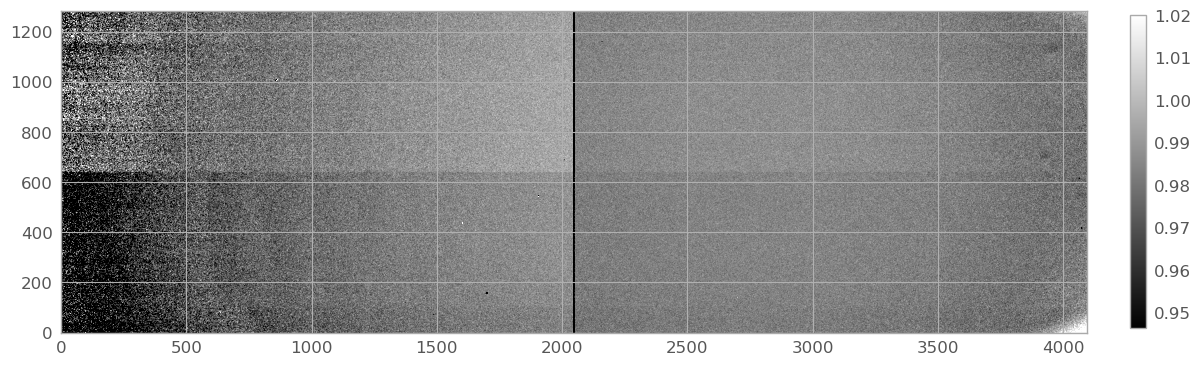

In [523]:
#FIRST STEP: READ AND MOVE THE FILES
File_type = "FLAT QUARTZ"
File_NR = '019'
file_01  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_01)

File_NR = '020'
file_10  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_10)

File_type = "FLAT QUARTZ"
File_NR = '041'
file_bias  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_bias)


#SECOND STEP: READ AND AVERAGE
hdu = SAMOS.read_SAMI_mosaic(file_01)
flat_01_data = hdu.data
hdu.data = flat_01_data

hdu1 = SAMOS.read_SAMI_mosaic(file_10)
flat_10_data = hdu1.data
hdu1.data = flat_10_data

hdu1 = SAMOS.read_SAMI_mosaic(file_bias)
bias_data = hdu1.data
hdu1.data = bias_data

flat_01_data_bias = flat_01_data - bias_data
flat_10_data_bias = flat_10_data - bias_data
flat = np.divide(flat_10_data_bias,flat_01_data_bias,out=np.full_like(flat_10_data_bias, 10), where=flat_01_data_bias!=0 )/10.
print(flat.shape)

#DISPLAY
image = flat
median = np.median(flat)
stddev = np.std(flat)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat,zmin=z0,zmax=z1)